# Further Two-layer model investigation 
Here we will:
- Test realistic forcing sets and see if we end up with the same final value dependence we observed earlier. ==> TODO
- Extend the time range to see if that changes the dependence ==> It does, it fixed the issue. 
- See whether the final value dependence is really just the last value, or maybe it's the last couple. ==> It was just the last value.. Still no real explanation. 

## Realistic Forcing

This will be taken from notebook 245.

In [2]:
import json
import numpy as np
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

import matplotlib.pyplot as plt
import json

In [ ]:

scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp370-lowNTCF-aerchemmip','ssp370-lowNTCF-gidden','ssp434','ssp460','ssp534-over','ssp585']


def run_tlm(args):
    in_forcing = forcing[scenarios[1]]['anthro'][:,i]  #changing this 
    driver = TwoLayerModel(
        extforce=in_forcing,   
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2020,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        outtime=np.arange(1750,2020),
        dt=0.2
        )
    output = driver.run()

exttime=np.arange(270),
            tbeg=1750,
            tend=2020,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2020),
            dt=1


## Longer Time Frame 
In notebook 245 they run the sim from 1750-2501. Let's see how this changes things.



In [ ]:
#Code from 245

def run_tlm(args):
        in_forcing = args['in_forcing']
        driver = TwoLayerModel(
            extforce=in_forcing,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=args['lamg'],
            t2x=None,
            eff=args['eff'],
            cmix=args['cmix'],
            cdeep=args['cdeep'],
            gamma_2l=args['gamma_2l'],
            outtime=np.arange(1750,2501),
            dt=0.2
        )
        output = driver.run()

In [3]:
runs = {}

In [5]:
#Step forcing. Basically just increase time frame from 1750-2020 to 1750-2501

stepDecrease = 4*np.ones(751)
stepDecrease[int(751/2):] = 1

steps = [stepDecrease]
step_names = ["Step Decrease"]

for (step, name) in zip(steps, step_names):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= step,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    runs[name] = out

#Took around 4mins to run ! I will increase dt

currently on Step Decrease... 


100%|██████████| 1000/1000 [00:20<00:00, 48.69it/s]


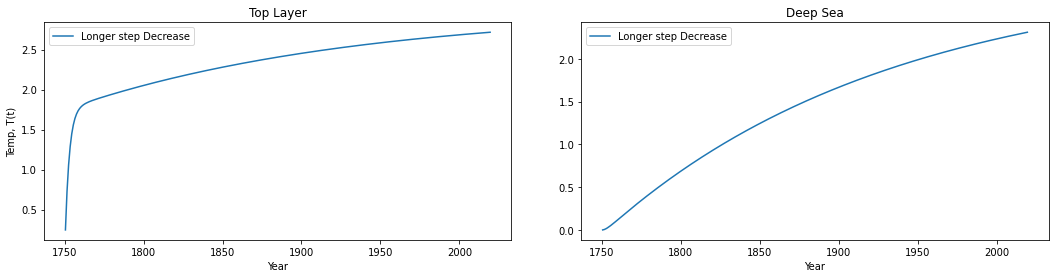

In [5]:
# Note time on x-axis is incorrect, it actually goes to 2501 rather than 2020.

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)')
layers = ["Top Layer", "Deep Sea"]
scen = "Longer step Decrease"


for (subpl, col, layer) in zip(axs, [0,1], layers):
    if col == 0:
        subpl.plot(out.time, out.tg, label = scen)
    else:
         subpl.plot(out.time, out.tlev[:,1], label = scen)
    subpl.title.set_text(layer)
    subpl.set_xlabel('Year')
    
for subpl in axs:
    
    subpl.legend()

In [6]:
#Step forcing. Basically just increase time frame from 1750-2020 to 1750-2501
#Now the step decrease will happen much earlier, same as when we did 1750-2020. 
# So essentially, more time for equilibrium to be reached
# dt = 1 to speed up run time

stepDecreaseEarly = 4*np.ones(751)
stepDecreaseEarly[int(270/2):] = 1

steps = [stepDecreaseEarly]
step_names = ["Step Decrease Early"]

for (step, name) in zip(steps, step_names):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= step,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    runs[name] = out



currently on Step Decrease Early... 


100%|██████████| 1000/1000 [00:17<00:00, 55.71it/s]


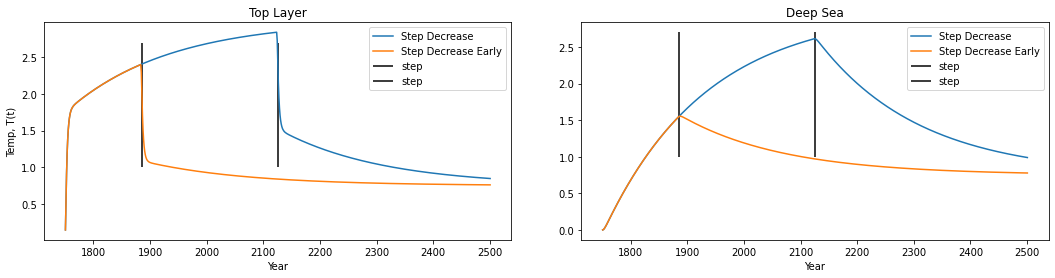

In [35]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = runs.keys()
run_outputs = runs.values()

layers = ["Top Layer", "Deep Sea"]
step_indices = [int(751/2), int(270/2) ]

for (run, scen, steptime) in zip (run_outputs, scenario_names, step_indices):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        #outtime=np.arange(1750.5,2501)
        subpl.vlines(outtime[steptime], 1, 2.7, label = "step")
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
    
for subpl in axs:
    
    subpl.legend()

This looks much better than before ! The step decrease looks a lot more like I expected. Now let's see what happens with a tophat..


100%|██████████| 1000/1000 [00:48<00:00, 20.65it/s]


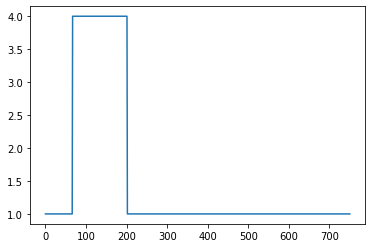

In [48]:

topHat = np.ones(751)
topHat[int(270/4):int(3*270/4)] = 4 #So this tophat occurs relatively early on in the simulation

plt.plot(topHat)

for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= topHat,
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        outtime=np.arange(1750.5,2501),
        dt=1
        )
        
    out = scm.run()

    runs["TopHat"] = out

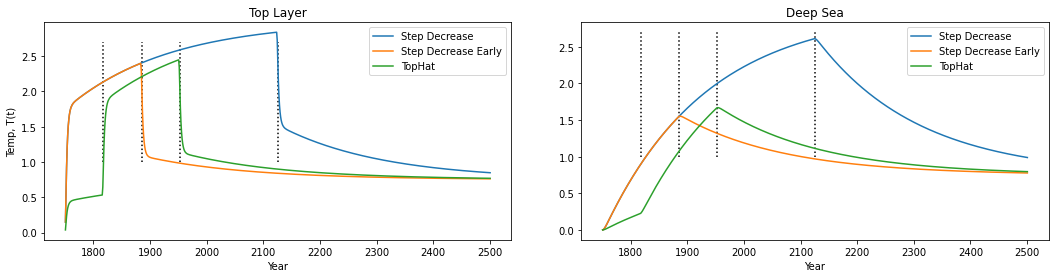

In [49]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = runs.keys()
run_outputs = runs.values()

layers = ["Top Layer", "Deep Sea"]
step_indices = [int(751/2), int(270/2), [int(270/4),int(3*270/4)]]

for (run, scen, steptime) in zip (run_outputs, scenario_names, step_indices):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        outtime=np.arange(1750.5,2501)
        subpl.vlines(outtime[steptime], 1, 2.7, linestyles="dotted")
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
    
for subpl in axs:
    
    subpl.legend()

Again, this is better, more what I expected. I still don't get why the other plot in the first notebook was so wrong... It was another typo :/

This longer time frame does show us a lot more though. But tophat should still have been visible in the first notebook?

currently on const. mag: 0... 


100%|██████████| 1000/1000 [00:09<00:00, 102.08it/s]


currently on const. mag: 1... 


100%|██████████| 1000/1000 [00:11<00:00, 83.48it/s]


currently on const. mag: 2... 


100%|██████████| 1000/1000 [00:13<00:00, 71.66it/s]


currently on const. mag: 4... 


100%|██████████| 1000/1000 [00:16<00:00, 60.17it/s]


currently on const. mag: 8... 


100%|██████████| 1000/1000 [00:13<00:00, 76.22it/s]


currently on const. mag: -1... 


100%|██████████| 1000/1000 [00:10<00:00, 91.60it/s]


currently on const. mag: -2... 


100%|██████████| 1000/1000 [00:11<00:00, 87.98it/s]


currently on const. mag: -4... 


100%|██████████| 1000/1000 [00:12<00:00, 78.28it/s]


currently on const. mag: -8... 


100%|██████████| 1000/1000 [00:12<00:00, 81.16it/s]


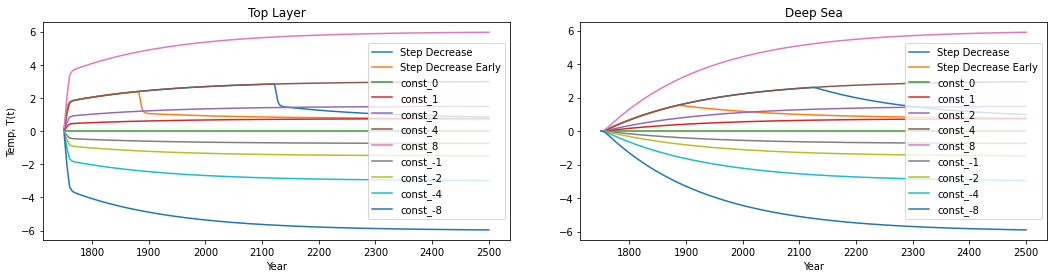

In [7]:
#We start with the constant forcing (a)

force_mags = [0,1,2,4,8,-1,-2,-4,-8]

for mag in force_mags:
    print(f"currently on const. mag: %s... "%mag)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= mag*np.ones(751),
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=5 #increased this from 1 to speed up running time
        )

        out = scm.run()
    
    runs[f"const_%s" %mag] = out

# Plotting the constant forcing scenarios

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = list(runs.keys())
run_outputs = list(runs.values())
layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
    
for subpl in axs:
    
    subpl.legend()



In [54]:
print(len(triangular))
print(len(np.arange(1750,2501)))

750
751


currently on Linear Increase... 


100%|██████████| 1000/1000 [00:10<00:00, 98.84it/s]


currently on Linear Decrease... 


100%|██████████| 1000/1000 [00:11<00:00, 84.65it/s]


currently on Triangular... 


100%|██████████| 1000/1000 [00:13<00:00, 75.28it/s]


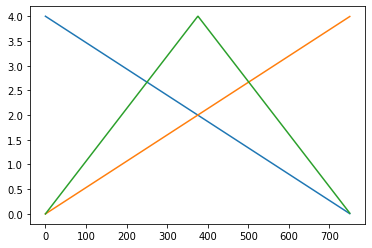

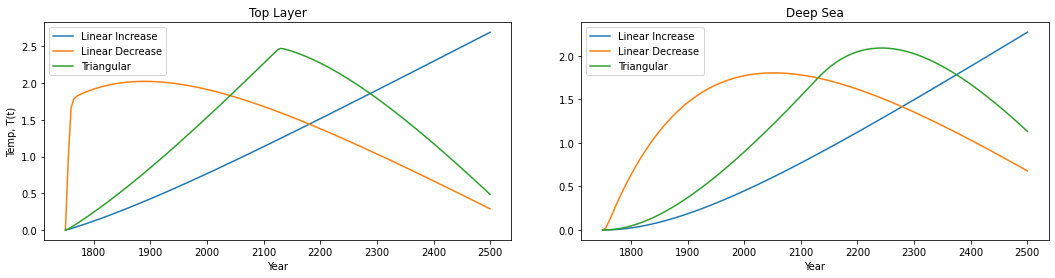

In [8]:
#Linear forcing. 

m = 4/751
xs = np.arange(751)

linearIncrease = m * xs
linearDecrease = -m * xs + 4
triangular = np.append(2*m * xs[:int(751/2)+1], -2*m * xs[:int(751/2)] + 4)

# Failed Debugging attempt
#linearDecrease[linearDecrease == 0] = 1
#triangular[triangular == 0] = 1

plt.plot(linearDecrease)
plt.plot(linearIncrease)
plt.plot(triangular)

steps = [linearIncrease, linearDecrease, triangular]
step_names_linear = ["Linear Increase", "Linear Decrease", "Triangular"]

for (step, name) in zip(steps, step_names_linear):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= step,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750,2501),
            dt=5
        )
        
        out = scm.run()
    runs[name] = out

# Plotting the linear forcing scenarios

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = ["Linear Increase", "Linear Decrease", "Triangular"]

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
    
for subpl in axs:
    
    subpl.legend()

Again, this is much better.

Observations:

-The instaneous increase for linear decrease is interesting. From this it looks like both layers experience thermal inertia to some degree. The deep sea layer to a much greater degree obviously.

The asymmetric shape of the triangular forcing is also interesting. This will be the thing to look at when thinking about reversibility.

currently on Exp. Increase... 


100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


currently on Exp. Decrease... 


100%|██████████| 1000/1000 [00:46<00:00, 21.30it/s]


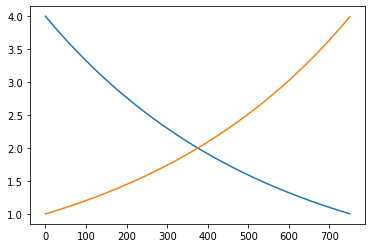

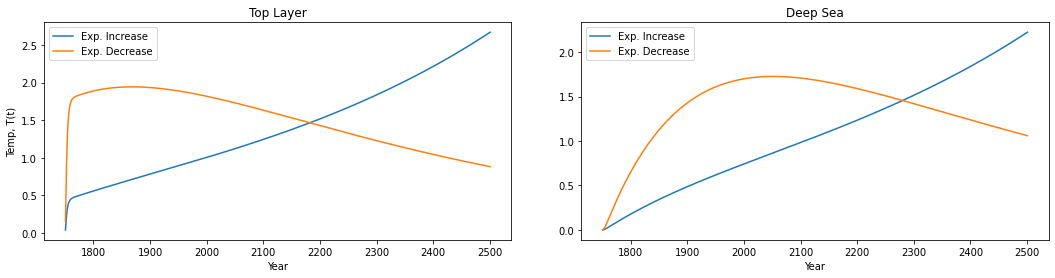

In [57]:
#Exponential forcing. 

a = np.log(4) / 751
xs = np.arange(751)

c = np.log(4)
b = -c / 751

expIncrease = np.exp(a * xs)
expDecrease = np.exp(b * xs + c)

plt.plot(expDecrease)
plt.plot(expIncrease)

steps = [expIncrease, expDecrease]
step_names_exp = ["Exp. Increase", "Exp. Decrease"]

for (step, name) in zip(steps, step_names_exp):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= step,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=1
        )
        
        out = scm.run()
    runs[name] = out

# Plotting the exp. forcing scenarios

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = ["Exp. Increase", "Exp. Decrease"]

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
    
for subpl in axs:
    
    subpl.legend()
    

The small bump (s-shape) in the deep sea exp. increase is interesting. Could we exaggerate this inflection point? What does it mean exactly?

In [157]:
#Sinuoidal forcing. 


xs = np.arange(751)

#freqs = [0.1, 1, 5, 10, 50] Old range.

fracs = np.array([0.001, 0.01, 0.1, 0.2, 0.3, 0.4]) #2/wavelengths

freqs = np.pi * fracs

names  = []

for i, e in enumerate(fracs):
    a = "Sin  k_max *  " + str(e)
    names.append(a)

step_names_sinx = names


for (freq, name) in zip(freqs, step_names_sinx):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= np.sin(xs * freq),
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=5
        )
        
        out = scm.run()
    runs[name] = out

currently on Sin  k_max *  0.001... 


100%|██████████| 1000/1000 [00:12<00:00, 82.32it/s]


currently on Sin  k_max *  0.01... 


100%|██████████| 1000/1000 [00:09<00:00, 102.91it/s]


currently on Sin  k_max *  0.1... 


100%|██████████| 1000/1000 [00:10<00:00, 99.38it/s]


currently on Sin  k_max *  0.2... 


100%|██████████| 1000/1000 [00:08<00:00, 120.69it/s]


currently on Sin  k_max *  0.3... 


100%|██████████| 1000/1000 [00:09<00:00, 101.61it/s]


currently on Sin  k_max *  0.4... 


100%|██████████| 1000/1000 [00:07<00:00, 128.79it/s]


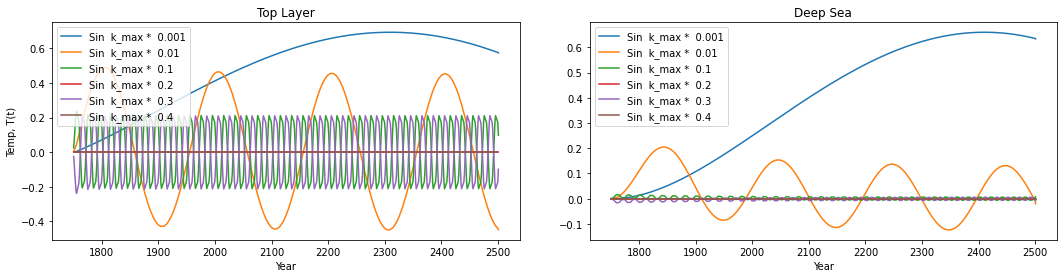

In [158]:
# Plotting the sinusoidal forcing scenarios

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = step_names_sinx

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
    
for subpl in axs:
    
    subpl.legend()

Now this is what we wanted to see !

They all had the same amplitude, but the sin(5t) seems to exhibit almost resonance with the deep sea layer.. !

Also, is the equilibrium in the deep sea layer shifting as well? Let's replot to investigate.



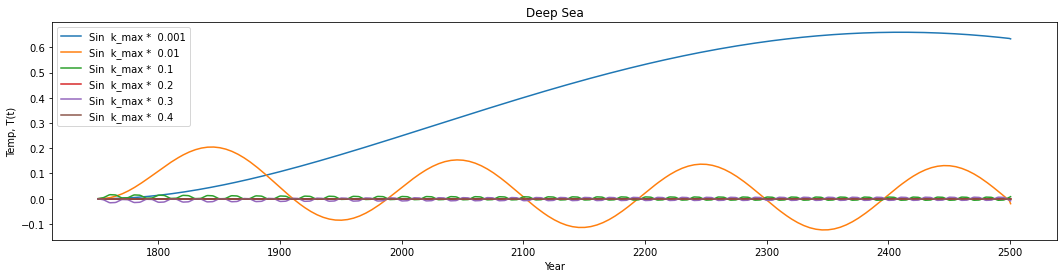

In [159]:
xs = np.arange(751)

fracs = np.array([0.001, 0.01, 0.1, 0.2, 0.3, 0.4]) #2/wavelengths

freqs = np.pi * fracs

names  = []

for i, e in enumerate(fracs):
    a = "Sin  k_max *  " + str(e)
    names.append(a)

step_names_sinx = names

fig, axs = plt.subplots(1)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs.set_ylabel('Temp, T(t)');


scenario_names = step_names_sinx

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
        axs.plot(run.time, run.tlev[:,1], label = scen)
        axs.title.set_text(layers[1])
        axs.set_xlabel('Year')
        axs.hlines(0, 1750.5,2501)
        axs.legend()


The equilibrium doesn't necessarily seem to shift, instead it seems to take some time to establish. Can we look into this further? Also, will freq 1 and 50 start being equal? How do I explain the frequency looking the same?


##### We could:

For freq = 1, 50, where the drift to equilibrium is most obvious:
- take intervals and find when the equilibrium starts being zero. ==> too complicated. no
- look at the max (and min) and how it changes. I think some math could simplify this. We can use the zeros to determine the intervals.

First, let's replot (again, i know) the target frequencies just to keep things clear.

Thought: Could the sampling frequency for f=50 just be too low and we are getting aliasing? Time to check the FA&Stats notes.

![Wow can't believe this works](./FA_Aliasing.png "Aliasing")


Our $\Delta x = 1$, so $k_{Nyquist} = \pi 0.5$. Any k larger than (or equal to) this will be aliased and is thus not worth looking at... ==> Let's update the frequencies.


Or from NumRec, since we are sampling at 1Hz, we have to have frequencies below 0.5Hz, which is $k < \pi$ (analogous for time instead of space, $\omega$ instead )


But this is just avoiding aliasing. We only get clear sinusoids if we take $k<0.5\pi$


In [76]:
print((2*np.pi/5))

1.2566370614359172


Yes this is indeed the problem.

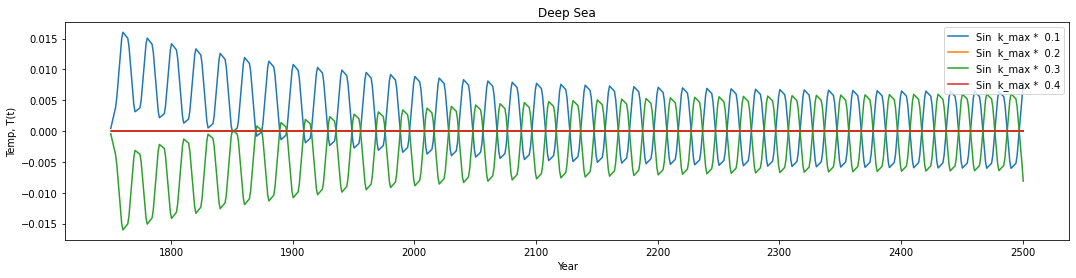

In [163]:
xs = np.arange(751)

fracs = np.array([0.1, 0.2, 0.3, 0.4]) #2/wavelengths

freqs = np.pi * fracs

names  = []

for i, e in enumerate(fracs):
    a = "Sin  k_max *  " + str(e)
    names.append(a)
    
step_names_sinx = names

fig, axs = plt.subplots(1)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs.set_ylabel('Temp, T(t)');


scenario_names = step_names_sinx

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
        axs.plot(run.time, run.tlev[:,1], label = scen)
        axs.title.set_text(layers[1])
        axs.set_xlabel('Year')
        axs.hlines(0, 1750.5,2501)
        axs.legend()


Still difficult to see.. what is happening with sin k_max*0.4? and sin k_max*0.2?  Let's replot.

0.1 and 0.3 still have interesting settle to equilibrium behaviour again.

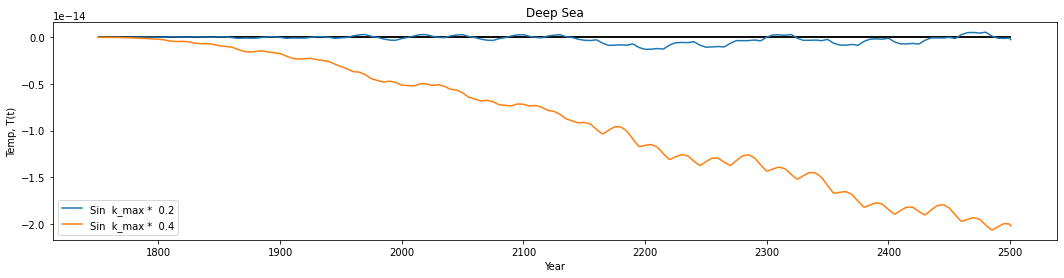

In [169]:
xs = np.arange(751)

fracs = np.array([0.2, 0.4]) #2/wavelengths

freqs = np.pi * fracs

names  = []

for i, e in enumerate(fracs):
    a = "Sin  k_max *  " + str(e)
    names.append(a)
    
step_names_sinx = names

fig, axs = plt.subplots(1)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs.set_ylabel('Temp, T(t)');


scenario_names = step_names_sinx

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
        axs.plot(run.time, run.tlev[:,1], label = scen)
        axs.title.set_text(layers[1])
        axs.set_xlabel('Year')
        axs.hlines(0, 1750.5,2501)
        axs.legend()

So they are pretty much 0... Weird because the forcing is definitely not like this:

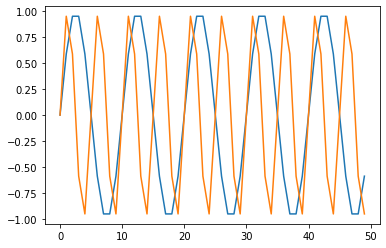

In [174]:
xs = np.arange(751)

fracs = np.array([0.2,0.4]) #2/wavelengths

freqs = np.pi * fracs

for k in freqs: plt.plot(xs[:50], np.sin(k*xs)[:50])

Why is this happening? Is it for all multiples of 0.2? maybe it has to do with dt?

In [176]:
#Sinuoidal forcing. 


xs = np.arange(751)

fracs = np.array([0.02, 0.2, 0.25, 0.4]) #2/wavelengths

freqs = np.pi * fracs

names  = []

for i, e in enumerate(fracs):
    a = "Sin  k_max *  " + str(e)
    names.append(a)

step_names_sinx = names


for (freq, name) in zip(freqs, step_names_sinx):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= np.sin(xs * freq),
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=1 #Changing dt from 5
        )
        
        out = scm.run()
    runs[name] = out

currently on Sin  k_max *  0.02... 


100%|██████████| 1000/1000 [00:45<00:00, 21.81it/s]


currently on Sin  k_max *  0.2... 


100%|██████████| 1000/1000 [00:42<00:00, 23.26it/s]


currently on Sin  k_max *  0.25... 


100%|██████████| 1000/1000 [00:42<00:00, 23.56it/s]


currently on Sin  k_max *  0.4... 


100%|██████████| 1000/1000 [00:46<00:00, 21.67it/s]


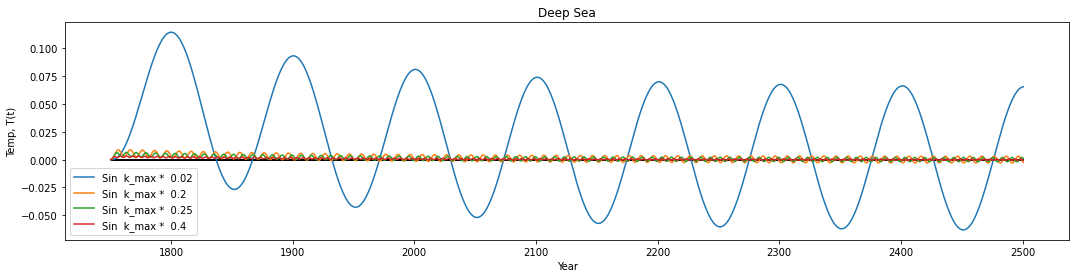

In [177]:
xs = np.arange(751)

fracs = np.array([0.02, 0.2, 0.25, 0.4]) #2/wavelengths

freqs = np.pi * fracs

names  = []

for i, e in enumerate(fracs):
    a = "Sin  k_max *  " + str(e)
    names.append(a)

step_names_sinx = names

fig, axs = plt.subplots(1)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs.set_ylabel('Temp, T(t)');


scenario_names = step_names_sinx

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
        axs.plot(run.time, run.tlev[:,1], label = scen)
        axs.title.set_text(layers[1])
        axs.set_xlabel('Year')
        axs.hlines(0, 1750.5,2501)
        axs.legend()


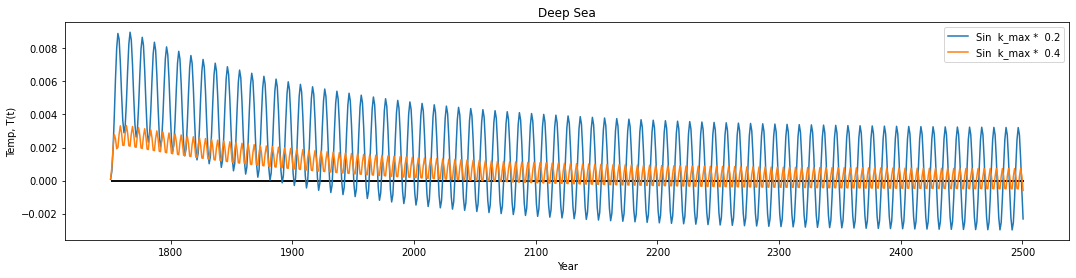

In [178]:
xs = np.arange(751)

fracs = np.array([0.2, 0.4]) #2/wavelengths

freqs = np.pi * fracs

names  = []

for i, e in enumerate(fracs):
    a = "Sin  k_max *  " + str(e)
    names.append(a)
    
step_names_sinx = names

fig, axs = plt.subplots(1)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs.set_ylabel('Temp, T(t)');


scenario_names = step_names_sinx

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
        axs.plot(run.time, run.tlev[:,1], label = scen)
        axs.title.set_text(layers[1])
        axs.set_xlabel('Year')
        axs.hlines(0, 1750.5,2501)
        axs.legend()

Okay, decreasing dt fixed that. Now we can see the equilibrium drift for all of these. 

NOTE however, how tiny all these amplitudes are. Are they even worth investigating?

Even the largest "resonance" one is actually tiny.

### Sinusoidal Forcing results in tiny temp perturbations.


## Looking at Emission Pathway Dependence

Compare constant 4xCO2, step 4xCO2 and Linear Increase

In [9]:
#We are only missing long time frame step increase

stepIncrease = 4*np.ones(751)
stepIncrease[:int(751/2)] = 1



steps = [stepIncrease]
step_names = ["Step Increase"]

for (step, name) in zip(steps, step_names):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= step,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    runs[name] = out

currently on Step Increase... 


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


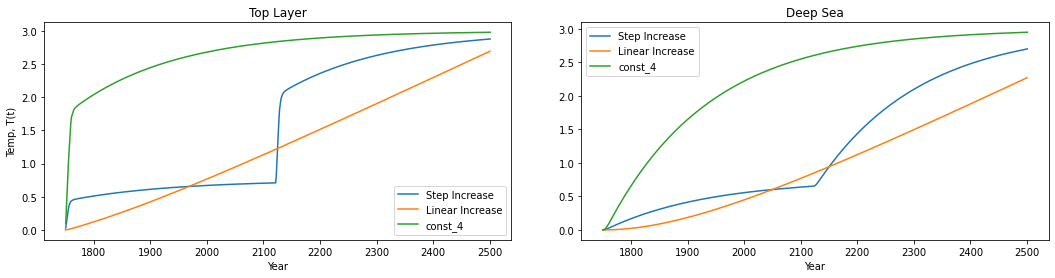

In [10]:

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = ["Step Increase", "Linear Increase", "const_4"]

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
    
for subpl in axs:
    
    subpl.legend()


This does show that heat uptake (and thus sea level rise), depends on emission pathway.

#  13/2/2023: Oscillatory triangles

This week we will be looking at top hat and triangular forcing in more depth. 

We want to get a feel for the the non-instantaneous response of the deep sea. The lag, not in signal transmission, but in response. We want to develop a better feeling for this. We can also then compare with analytical functions...

So plan:
-   positive followed by negative triangular forcing, compare with meeting notes
-   top hat forcing of widths 5,50,200 years
-   triangular forcing of widths 5,50,200 years
-   look at analytical solution to step, extend to top hat?
-   oscillatory tophat forcing of widths 5,50,200 years (adjust so same wavelength as pulsed forcing )
-   link analytical expression to what we see 
-   look at analytical solution triangular.
-   oscillatory triangular forcing of widths 5,50,200 years (adjust so same wavelength as pulsed forcing )
-   link analytical expression to what we see 
-   Rerun everything with varying parameters. See effect on lag.
